In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [27]:
# Load Dataset
df = pd.read_csv("Binary.csv")

In [28]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [29]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [86]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [87]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size):
        super(OptimizedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # Ensure output is 1

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  # ✅ Keep this ReLU
        x = self.fc4(x)  # ✅ Do not apply activation before final layer
        return self.sigmoid(x)  # ✅ Sigmoid at the final output

In [88]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedMLP(input_size=X_train.shape[1]).to(device)

In [89]:
# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning Rate Scheduler

In [90]:
# Training Loop with Early Stopping
epochs = 100
best_val_loss = float("inf")
patience = 10  # Stop if validation loss doesn't improve for 5 consecutive epochs
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    
    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100], Loss: 0.5930, Val Loss: 0.4918
Epoch [2/100], Loss: 0.4113, Val Loss: 0.3612
Epoch [3/100], Loss: 0.3346, Val Loss: 0.3347
Epoch [4/100], Loss: 0.3129, Val Loss: 0.3018
Epoch [5/100], Loss: 0.2721, Val Loss: 0.2723
Epoch [6/100], Loss: 0.2387, Val Loss: 0.2555
Epoch [7/100], Loss: 0.2126, Val Loss: 0.2293
Epoch [8/100], Loss: 0.1849, Val Loss: 0.2208
Epoch [9/100], Loss: 0.1671, Val Loss: 0.2139
Epoch [10/100], Loss: 0.1352, Val Loss: 0.2082
Epoch [11/100], Loss: 0.1243, Val Loss: 0.2096
Epoch [12/100], Loss: 0.1097, Val Loss: 0.2106
Epoch [13/100], Loss: 0.1164, Val Loss: 0.2109
Epoch [14/100], Loss: 0.1103, Val Loss: 0.2109
Epoch [15/100], Loss: 0.1058, Val Loss: 0.2128
Epoch [16/100], Loss: 0.1021, Val Loss: 0.2122
Epoch [17/100], Loss: 0.0994, Val Loss: 0.2116
Epoch [18/100], Loss: 0.0963, Val Loss: 0.2119
Epoch [19/100], Loss: 0.0987, Val Loss: 0.2103
Epoch [20/100], Loss: 0.0992, Val Loss: 0.2103
Early stopping triggered.


In [91]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

In [92]:
# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average="binary")
cm = confusion_matrix(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Accuracy: 0.9541
Precision: 0.9588, Recall: 0.9894, F1-Score: 0.9738


In [93]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.96      0.99      0.97        94

    accuracy                           0.95       109
   macro avg       0.94      0.86      0.89       109
weighted avg       0.95      0.95      0.95       109



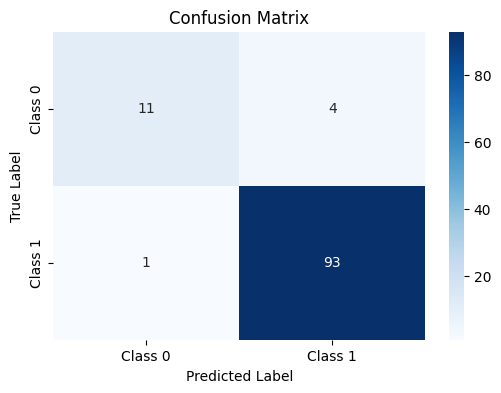

In [94]:
# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

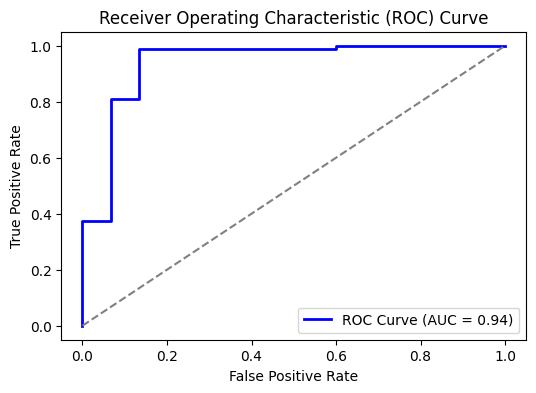

In [95]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()